# Submitting user-transpiled circuits using primitives

To get the best performance from your circuits, IBM Quantum's runtime service will pass all circuits through Qiskit's transpiler before running them. While this is usually a good thing, we might sometimes want to disable this by passing the argument `skip_transpilation=True` to the primitive we're using.

For example, we may know better than the transpiler in some cases, or want to target a specific subset of qubits on a specific device. In this tutorial, we'll disable automatic transpilation to test the performance of different transpiler settings. This example will take you through the full process of creating, transpiling, and submitting circuits.

## Transpiling circuits for IBM Quantum devices

In the code cell below, we create a small [`QuantumVolume`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QuantumVolume.html) circuit that our transpiler will try to optimize. `QuantumVolume` creates randomized circuits, so we set a seed for reproducibility. We then simulate the ideal distribution (what we'd expect to measure if we ran this on a perfect quantum computer, an infinite number of times) for comparison later. 

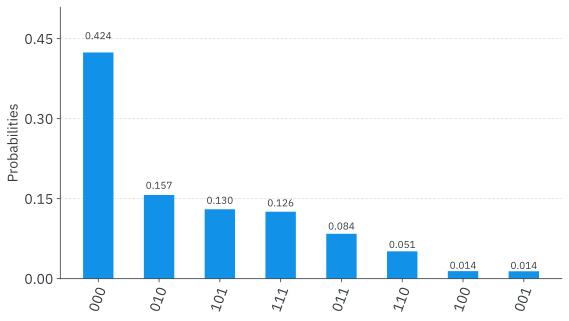

In [1]:
from qiskit.circuit.library import QuantumVolume
qc = QuantumVolume(num_qubits=3, depth=6, seed=10)

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
ideal_distribution = Statevector.from_instruction(qc)\
                                .probabilities_dict()

from qiskit.visualization import plot_histogram
plot_histogram(ideal_distribution, sort='value_desc')

Next, we need to choose a backend to transpile for. In the cell below, we create a service instance, which we'll use to start a session, and get the backend object, which contains information for the transpiler. Since the transpilation process depends on the device, we'll ask the runtime service for a specific device by name. In this example, we'll use `ibm_algiers`.

In [2]:
from qiskit_ibm_runtime import IBMRuntimeService
service = IBMRuntimeService()
backend = service.backend('ibm_algiers')

Next, we transpile the circuits for our backend. We're going to compare the performance of the transpiler with `optimization_level` set to `0` against `3`. In the cell below, we transpile `qc` for both values of `optimzation_level`, print the number of CNOT gates, and add the transpiled circuits to a list. Some of the transpiler's algorithms are randomized, so we set a seed for reproducibility.

In [3]:
# Need to add measurements to the circuit
qc.measure_all()

from qiskit import transpile
circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc,
                     backend,
                     optimization_level=optimization_level,
                     seed_transpiler=6)
    print(f'CNOTs (optimization_level={optimization_level}): ',
          t_qc.count_ops()['cx'])
    circuits.append(t_qc)

CNOTs (optimization_level=0):  19
CNOTs (optimization_level=3):  9


## Run user-transpiled circuits using IBM Quantum runtime

At this point, we have a list of circuits (named `circuits`) transpiled for `ibm_algiers`. In the cell below, we create an instance of the sampler primitive, and start a session using the context manager (`with ... as ... :`), which automatically opens and closes the session for us. This is where we pass the `skip_transpilation=False` argument.

Within the context manager, we sample the circuits and store the results to `results`.

In [4]:
from qiskit_ibm_runtime import IBMSampler
ibm_sampler = IBMSampler(service, backend)

with ibm_sampler(circuits=circuits, skip_transpilation=True) as sampler:
    result = sampler(
        circuit_indices=[0,1],  # sample circuits[0] and circuits[1]
        shots=8000
    )

Finally, we can plot the results from the device runs against the ideal distribution. For each measured string, the leftmost bar is the ideal distribution, the central bar is the circuit transpiled with `optimization_level=3`, and the rightmost bar is the circuit transpiled with `optimization_level=0`). 

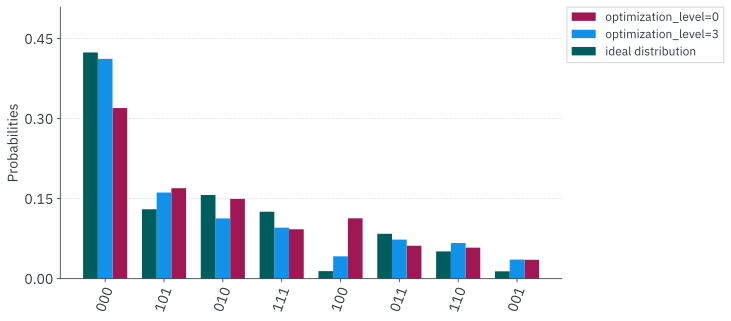

In [5]:
from qiskit.visualization import plot_histogram
plot_histogram(result.quasi_dists+[ideal_distribution],
               sort='value_desc', bar_labels=False,
               legend=['optimization_level=0',
                       'optimization_level=3',
                       'ideal distribution'])

In [6]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.2', 'qiskit-aer': '0.9.1', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': '0.9.5', 'qiskit': '0.34.0', 'qiskit-nature': '0.3.0', 'qiskit-finance': '0.2.1', 'qiskit-optimization': '0.2.3', 'qiskit-machine-learning': '0.2.1'}

In [7]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.2.0'